<a href="https://colab.research.google.com/github/SYAMINI-17/FMML_ASSGNIMENT-2024/blob/main/FMML_Module_9_Lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 3**
### Module coordinator: Kushagra Agarwal

## 1. Understanding Convolutions

<img src="https://miro.medium.com/max/464/0*e-SMFTzO8r7skkpc" width=650px/>

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [23]:
# Importing some pytorch packages
import torch
from torch.nn import Conv2d

Central to CNNs, a convolution operation is a linear element-wise multiplication operation between a small filter/kernel and same-sized patch from the image. We move this filter over the image like a sliding window from top left to bottom right. For each point on the image, a value is calculated based on the filter using a convolution operation. These filters can do simplest task like checking if there is a vertical line in the image or complicated task like detecting a human eye in the image.

Let's look at the convolution formula:

Convolution between image
$f(x, y)$ and kernel $k(x, y)$ is
$$f(x,y) * k(x,y) = \sum \limits _{i=0} ^{W-1} \sum \limits _{j=0} ^{H-1} f(i, j) k(x − i, y − j)$$

where $W$ and $H$ are the the width and height of the image.

The code demonstrates the convolution operation of a 2D matrix (image) with various filters

<img src="https://www.researchgate.net/profile/Chaim-Baskin/publication/318849314/figure/fig1/AS:614287726870532@1523469015098/Image-convolution-with-an-input-image-of-size-7-7-and-a-filter-kernel-of-size-3-3.png" alt="Convolution" width=650px height=280px/>

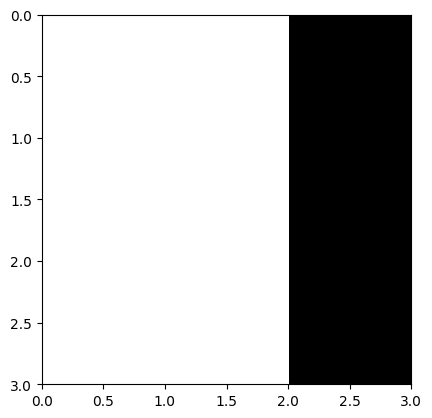

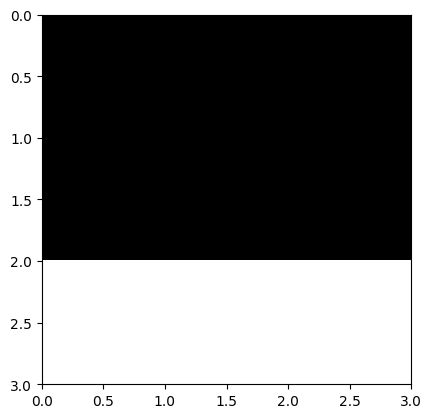

In [24]:
# 2D 3x3 binary image with vertical edge
image1 = np.array([[1,1,0], [1,1,0], [1,1,0]])

# 2D 3x3 binary image with horizontal edge
image2 = np.array([[0,0,0], [0,0,0], [1,1,1]])

# On plotting the images
plt.imshow(image1, cmap='gray', extent=[0, 3, 3, 0])
plt.show()
plt.imshow(image2, cmap='gray', extent=[0, 3, 3, 0])
plt.show()

In [25]:
# Vertical Line filter
filter = np.array([[1,0,-1],
                   [1,0,-1],
                   [1,0,-1]])

# Applying filter to first image
output = np.sum(np.multiply(image1, filter))
print('Output from first image: ', output)

# Applying filter to second image
output = np.sum(np.multiply(image2, filter))
print('Output from second image: ', output)

Output from first image:  3
Output from second image:  0


In [26]:
# Horizontal edge filter
filter = np.array([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]])

output = np.sum(np.multiply(image1, filter))
print('Output from first image: ', output)

output = np.sum(np.multiply(image2, filter))
print('Output from second image: ', output)

Output from first image:  0
Output from second image:  3


Non-zero output suggests that there is a vertical edge present in the first image and not present in the second image. Similarly, horizontal edge is detected in second.

Let's define a function to use convolution layer from Pytorch and use our own kernel to detect edges in image

In [27]:
def apply_conv(image, kernel, padding=0, stride=1):

  #--------IMAGE PREPROCESSING-------
  image = torch.from_numpy(image)
  # Pytorch requires input to convolution in (N,C,H,W), where N = batch size and C=#channels in input
  input = image.view((1,1,image.shape[0], image.shape[1]))

  # --------------KERNEL-------------
  kernel = torch.from_numpy(kernel.astype(np.float32))

  # Pytorch requires kernel of shape (N,C,H,W), where N = batch size and C=#channels in input
  kernel = kernel.view((1,1,kernel.shape[0], kernel.shape[1]))

  # ---------CONVOLUTION LAYER from Pytorch--------
  conv = Conv2d(in_channels=1, out_channels=1, kernel_size=kernel.shape, padding=padding, stride=stride)

  # Set the kernel weights in the convolution layer
  conv.weight = torch.nn.Parameter(kernel)

  # ---------APPLY CONVOLUTION--------
  output = conv(input.float())
  output_img = output.data.numpy()  # Tensor to back in numpy
  output_img = output_img.reshape((-1, output_img.shape[-1])) # Reshape to 2D image

  return output_img

## Pooling Layers

Pooling layers are used to reduce the dimensions of the feature maps. Thus, it reduces the number of parameters to learn and the amount of computation performed in the network. The pooling layer summarises the features present in a region of the feature map generated by a convolution layer.

1) Max Pooling:

<img src='https://media.geeksforgeeks.org/wp-content/uploads/20190721025744/Screenshot-2019-07-21-at-2.57.13-AM.png' height=150px/>

2) Average Pooling:

<img src='https://media.geeksforgeeks.org/wp-content/uploads/20190721030705/Screenshot-2019-07-21-at-3.05.56-AM.png' height=150px/>

## Softmax layer/activation
Recall that logistic regression produces a decimal between 0 and 1.0. For example, a logistic regression output of 0.8 from an email classifier suggests an 80% chance of an email being spam and a 20% chance of it being not spam. Clearly, the sum of the probabilities of an email being either spam or not spam is 1.0.

Softmax extends this idea into a multi-class world. That is, Softmax assigns decimal probabilities to each class in a multi-class problem. Those decimal probabilities must add up to 1.0. This additional constraint helps training converge more quickly than it otherwise would.
Softmax is implemented through a neural network layer just before the output layer. The Softmax layer must have the same number of nodes as the output layer.

<img src='https://miro.medium.com/max/1400/1*ReYpdIZ3ZSAPb2W8cJpkBg.jpeg' height=170px />

## Learning to train a CNN network

In [31]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [32]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Classes in CIFAR10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [33]:
print('Training data shape : ', trainset.data.shape, len(trainset.targets))
print('Testing data shape : ', testset.data.shape, len(testset.targets))

# Find the unique numbers from the train labels
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Training data shape :  (50000, 32, 32, 3) 50000
Testing data shape :  (10000, 32, 32, 3) 10000
Total number of outputs :  10
Output classes :  ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [34]:
def train(num_epochs, model, train_loader, loss_func, optimizer):

  # Training mode
  model.train()

  train_losses = []
  train_acc = []

  # Train the model
  for epoch in range(num_epochs):
    running_loss = 0
    running_acc = 0
    for i, (images, labels) in enumerate(train_loader):

      # clear gradients for this training step
      optimizer.zero_grad()

      # Forward pass
      output = model(images)

      # Calculate loss
      loss = loss_func(output, labels)

      # Backpropagation, compute gradients
      loss.backward()

      # Apply gradients
      optimizer.step()

      # Running loss
      running_loss += loss.item()

      # indices of max probabilities
      _, preds = torch.max(output, dim=1)

      # Calculate number of correct predictions
      correct = (preds == labels).sum().item()
      running_acc += correct

    # Average loss and acc values
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_acc / len(train_loader.dataset)

    train_losses.append(epoch_loss)
    train_acc.append(epoch_acc)
    print ('Epoch {}/{}, Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch + 1, num_epochs, epoch_loss, epoch_acc*100))

  return train_losses, train_acc

In [35]:
def test_model(model, testloader):
  correct = 0
  total = 0
  # Deactivate autograd engine (don't compute grads since we're not training)
  with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Calculate outputs by running images through the network
        outputs = model(images)
        # The class with the highest value is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  print('Accuracy of the network: %d %%' % (
      100 * correct / total))

In [36]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 512)
        self.fc2 = nn.Linear(512, 128)
        # output layer 10 classes
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flatten all dimensions except batch
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [37]:
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [38]:
criterion = nn.CrossEntropyLoss()

In [39]:
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

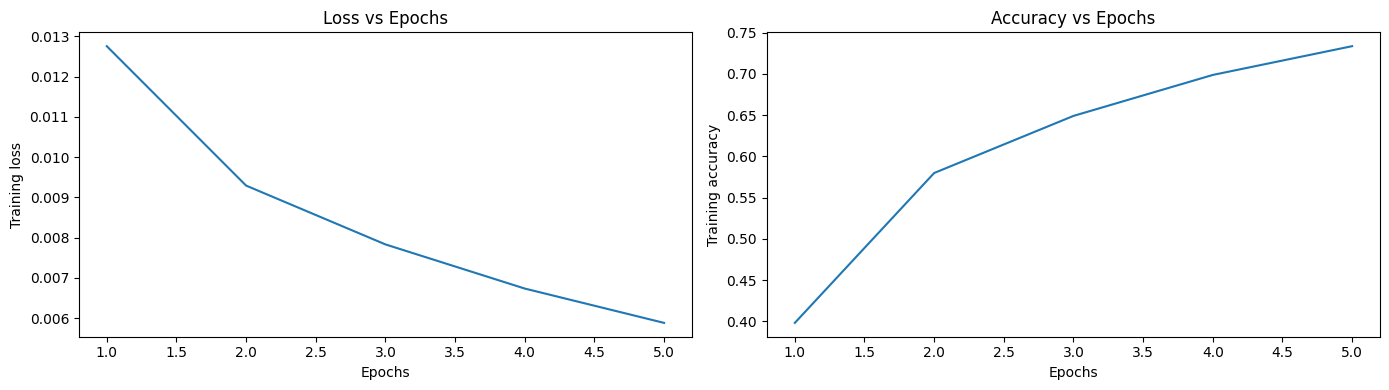

In [41]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(14, 4))

# Subplot 1: Loss vs Epochs
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(np.arange(1, len(train_losses) + 1), train_losses)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training loss')
ax1.set_title('Loss vs Epochs')

# Subplot 2: Accuracy vs Epochs
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(np.arange(1, len(train_acc) + 1), train_acc)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Training accuracy')
ax2.set_title('Accuracy vs Epochs')

plt.tight_layout()
plt.show()

In [42]:
# Accuracy on test data after training
test_model(model, testloader)

Accuracy of the network: 67 %


## Questions
1) List some reasons why we should prefer CNN over ANN for image classification?

2) Try improving the CNN performance further by tuning the hyperparameters(epochs, optimizer, LR etc). Report the improved test accuracy.

3) What happens if you reduce the number of convolution layers to only 1?

4) Why didn't we use the Softmax activation in the last layer of CNN?


ANSWER 1

Sure, here are some reasons why Convolutional Neural Networks (CNNs) are preferred over traditional Artificial Neural Networks (ANNs) for image classification tasks:

Feature Learning: CNNs automatically learn features from the input images, reducing the need for handcrafted feature extraction, which is required in traditional ANNs.

Translation Invariance: CNNs are designed to understand spatial hierarchies in images, making them translation invariant. This means they can identify patterns regardless of where they appear in the image.

Parameter Sharing: CNNs use parameter sharing, where a set of weights is applied to all parts of the image, reducing the total number of parameters. This allows CNNs to learn from fewer data and generalize better.

Sparsity of Connections: In CNNs, neurons are only connected to a small local region of the input volume, which reduces the number of parameters and makes the model easier to train.

Pooling Layers: CNNs typically include pooling layers, which reduce the spatial dimensions of the input, leading to lower memory requirements and faster computation.

Hierarchical Structure: CNNs consist of multiple layers that capture increasingly abstract features of the image, leading to a hierarchical representation of the input.

Weight Sharing: CNNs share weights across the input space, making them well-suited for tasks where the spatial relationship of the features matters, such as image classification.

Regularization: CNNs have inherent regularization properties due to weight sharing and pooling, reducing the risk of overfitting, especially when dealing with limited training data.

ANSWER 2

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Assuming you have defined your CNN model as 'Net'

# Hyperparameters
num_epochs = 20
batch_size = 128
learning_rate = 0.001

# Data preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Define the model
model = Net()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
total_step = len(trainloader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/20], Step [100/391], Loss: 1.6373
Epoch [1/20], Step [200/391], Loss: 1.5112
Epoch [1/20], Step [300/391], Loss: 1.5514
Epoch [2/20], Step [100/391], Loss: 1.2268
Epoch [2/20], Step [200/391], Loss: 1.1556
Epoch [2/20], Step [300/391], Loss: 1.1416
Epoch [3/20], Step [100/391], Loss: 0.9918
Epoch [3/20], Step [200/391], Loss: 0.9453
Epoch [3/20], Step [300/391], Loss: 0.9695
Epoch [4/20], Step [100/391], Loss: 1.0862
Epoch [4/20], Step [200/391], Loss: 0.9521
Epoch [4/20], Step [300/391], Loss: 0.8745
Epoch [5/20], Step [100/391], Loss: 0.8793
Epoch [5/20], Step [200/391], Loss: 0.9072
Epoch [5/20], Step [300/391], Loss: 0.8324
Epoch [6/20], Step [100/391], Loss: 0.8499
Epoch [6/20], Step [200/391], Loss: 0.6714
Epoch [6/20], Step [300/391], Loss: 0.6588
Epoch [7/20], Step [100/391], Loss: 0.5469
Epoch [7/20], Step [200/391], Loss: 0.6491
Epoch [7/20], Step [300/391], Loss: 0.6285
Epoch [8/20], Step [1

ANSWER 3

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Define the CNN model with only one convolutional layer
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(6 * 14 * 14, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 6 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Hyperparameters
num_epochs = 20
batch_size = 128
learning_rate = 0.001

# Data preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Define the model
model = Net()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
total_step = len(trainloader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/20], Step [100/391], Loss: 1.6168
Epoch [1/20], Step [200/391], Loss: 1.4378
Epoch [1/20], Step [300/391], Loss: 1.5152
Epoch [2/20], Step [100/391], Loss: 1.2616
Epoch [2/20], Step [200/391], Loss: 1.2082
Epoch [2/20], Step [300/391], Loss: 1.2222
Epoch [3/20], Step [100/391], Loss: 1.1249
Epoch [3/20], Step [200/391], Loss: 1.2186
Epoch [3/20], Step [300/391], Loss: 1.2407
Epoch [4/20], Step [100/391], Loss: 1.2509
Epoch [4/20], Step [200/391], Loss: 1.0157
Epoch [4/20], Step [300/391], Loss: 1.2400
Epoch [5/20], Step [100/391], Loss: 1.1654
Epoch [5/20], Step [200/391], Loss: 1.0295
Epoch [5/20], Step [300/391], Loss: 1.0632
Epoch [6/20], Step [100/391], Loss: 0.9819
Epoch [6/20], Step [200/391], Loss: 1.1104
Epoch [6/20], Step [300/391], Loss: 1.0459
Epoch [7/20], Step [100/391], Loss: 0.9910
Epoch [7/20], Step [200/391], Loss: 0.9845
Epoch [7/20], Step [300/391], Loss: 1.1276
Epoch [8/20], Step [1

ANSWER 4

In PyTorch, when using nn.CrossEntropyLoss, the softmax operation is already included in the loss function. Therefore, we don't need to add a softmax activation to the output layer of the CNN. The raw output from the last layer is sufficient for computing the loss.